# NASA Web Content Recommendation Models

**Problem Statement**<br>
The Head of Digital at NASA has a goal to increase visitors to the NASA website in the next year. To achieve this, she wants to improve the overall customer experience by tailoring the content and layout on the website based on visitor usage information and behaviour patterns.

**Solution Overview**<br>
Here is an end-to-end solution for the Digital team at NASA to implement into their website to tailor fit content for their visitors. The solution consists of two key components.
* Web insight dashboard
    * Suitable for both ad-hoc analysis of visitor behaviour and monthly reporting of web performance
    * A suite of functions developed in R that automates analytics of web traffic, content popularity, top visitors and server response
    * The output from these functions are readily available to integrate with any downstream reporting and visualisation tools
    * An additional R function to collate and pre-process data for modelling purposes
* Content Recommendation Engine
    * A streamlined process built in Python to leverage data produced via the R functions to build propensity models for content on NASA web
    * One propensity model per content type available on NASA web
    * Solution design for content recommendation engine - how all the propensity models fit together such that NASA web can provide content most relevant and contextual to the visitor at any point in time

**Step 1: Load required Python libraries**

In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt

**Step 2: Load the NASA Web Log modelling dataset**

In [2]:
df = pd.read_csv('../Data/nasa_modl_data.csv')
df.head()

,my_ranks,root,hod,dow,dom,root_lag1,root_lag2,root_lag3,depth_lag1,depth_lag2,depth_lag3,url_type_lag1,url_type_lag2,url_type_lag3,d_from_launch1,d_from_launch2
0,1,ksc.html,12,2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,57
1,2,images,12,2,11,ksc.html,NaN,NaN,1.0,NaN,NaN,html,NaN,NaN,1,57
2,3,images,12,2,11,images,ksc.html,NaN,2.0,1.0,NaN,gif,html,NaN,1,57
3,4,images,12,2,11,images,images,ksc.html,2.0,2.0,1.0,gif,gif,html,1,57
4,5,images,12,2,11,images,images,images,2.0,2.0,2.0,gif,gif,gif,1,57


**Step 3: Feature engineering (one hot encoding and define model outcomes)**

In [3]:
# First we need one hot encoding to transform our root_lag, depth_lag and url_type_lag features into boolean features
df = pd.concat([df, pd.get_dummies(df['root_lag1'].fillna('NA'), prefix = 'root_lag1')], sort = False, axis = 1)
df = pd.concat([df, pd.get_dummies(df['root_lag2'].fillna('NA'), prefix = 'root_lag2')], sort = False, axis = 1)
df = pd.concat([df, pd.get_dummies(df['root_lag3'].fillna('NA'), prefix = 'root_lag3')], sort = False, axis = 1)

df = pd.concat([df, pd.get_dummies(df['depth_lag1'].fillna('NA'), prefix = 'depth_lag1')], sort = False, axis = 1)
df = pd.concat([df, pd.get_dummies(df['depth_lag2'].fillna('NA'), prefix = 'depth_lag2')], sort = False, axis = 1)
df = pd.concat([df, pd.get_dummies(df['depth_lag3'].fillna('NA'), prefix = 'depth_lag3')], sort = False, axis = 1)

df = pd.concat([df, pd.get_dummies(df['url_type_lag1'].fillna('NA'), prefix = 'url_type_lag1')], sort = False, axis = 1)
df = pd.concat([df, pd.get_dummies(df['url_type_lag2'].fillna('NA'), prefix = 'url_type_lag2')], sort = False, axis = 1)
df = pd.concat([df, pd.get_dummies(df['url_type_lag3'].fillna('NA'), prefix = 'url_type_lag3')], sort = False, axis = 1)

# Similarly apply one hot encoding to root columns, this is our prediction outcome for the 3 classification models we will build
df = pd.concat([df, pd.get_dummies(df['root'].fillna('NA'), prefix = 'label')], sort = False, axis = 1)

# Dropping the original columns
df = df.drop(['root','root_lag1','root_lag2','root_lag3',
              'depth_lag1','depth_lag2','depth_lag3','url_type_lag1',
              'url_type_lag2', 'url_type_lag3'], axis=1)

# Separate out the dataset into the feature set and the label (outcome) set
label_cols = [col for col in df.columns if 'label' in col]
other_cols = [col for col in df.columns if col not in label_cols]
labels = pd.DataFrame(df[label_cols])

df = df[other_cols]
df = df.fillna('NA')

# Print out key info regarding our feature and label (outcome) datasets
print("Our feature table has {:2d} rows and {:2d} columns".format(df.shape[0], df.shape[1]))
print("Our label table has {:2d} rows and {:2d} columns".format(labels.shape[0], labels.shape[1]))
print(df.dtypes)
print(labels.dtypes)

Our feature table has 3440364 rows and 135 columns
Our label table has 3440364 rows and 21 columns
my_ranks               int64
hod                    int64
dow                    int64
dom                    int64
d_from_launch1         int64
                       ...  
url_type_lag3_mpg      uint8
url_type_lag3_other    uint8
url_type_lag3_pl       uint8
url_type_lag3_txt      uint8
url_type_lag3_xbm      uint8
Length: 135, dtype: object
label_cgi-bin           uint8
label_elv               uint8
label_facilities        uint8
label_facts             uint8
label_finance           uint8
label_history           uint8
label_htbin             uint8
label_icon              uint8
label_icons             uint8
label_images            uint8
label_ksc.html          uint8
label_mdss              uint8
label_msfc              uint8
label_other             uint8
label_payloads          uint8
label_persons           uint8
label_procurement       uint8
label_shuttle           uint8
label_software 

**Step 4: Split dataset into train and test**

In [4]:
# We will split 80% into training and 20% into testing (to validate the model we will be building later)
X_train, X_test, y_train, y_test = train_test_split(df, labels['label_images'], test_size=0.2, random_state=42)
print("We have {:2d} rows of data in our training set".format(X_train.shape[0]))
print("And {:2d} rows in our testing set".format(X_test.shape[0]))

We have 2752291 rows of data in our training set
And 688073 rows in our testing set


**Step 5: Build and evaluate predictive model for image content** <br>
Here comes the fun part. We will first develop a model to predict a user's likelihood to visit content under the **image** root URL. Our features are based off the user's previous web browsing behaviour on the site and a number of attributes relating to their current visit. These include: 
* last 3 root URL subpages the user visited;
* last 3 URL levels the user visited (e.g. if the user was in /image/xxx/ this would be 2);
* last 3 URL types the user visited (e.g. if the user visted /image/nasa.jpg, this would be jpg);
* hour of day for current visit;
* day of week for current visit; and
* day of month for current visit

In [5]:
# call the XGBClassifier from xgboost library and set seed=0 to ensure reproducibility of results
clf_XGB = XGBClassifier(eta = 0.5, max_depth = 1, seed = 0, gamma = 2)
# fit the clf_XGB on training data
clf_XGB.fit(X_train, y_train)
# make predictions with test data
clf_XGB_predictions = clf_XGB.predict(X_test)
# evaluate predictions with accuracy metric
clf_XGB_accuracy_train = accuracy_score(y_train, clf_XGB.predict(X_train))
clf_XGB_accuracy_test = accuracy_score(y_test, clf_XGB_predictions)
# evaluate predictions with F1-score metric
clf_XGB_f1_train = f1_score(y_train, clf_XGB.predict(X_train))
clf_XGB_f1_test = f1_score(y_test, clf_XGB_predictions)
# evaluate probabilities with gini metric
clf_XGB_score_train = clf_XGB.predict_proba(X_train)
gini_train = (roc_auc_score(y_train, clf_XGB_score_train[:,1]) - 0.5) * 2
clf_XGB_score_test = clf_XGB.predict_proba(X_test)
gini_test = (roc_auc_score(y_test, clf_XGB_score_test[:,1]) - 0.5) * 2

print("XGB Classifier Training Performance: [Accuracy: {:.4f}, F1-score: {:.4f}, Gini: {:.4f}]".format(clf_XGB_accuracy_train, 
                                                                                                       clf_XGB_f1_train,
                                                                                                      gini_train))
print("XGB Classifier Testing Performance: [Accuracy: {:.4f}, F1-score: {:.4f}, Gini: {:.4f}]".format(clf_XGB_accuracy_test, 
                                                                                                      clf_XGB_f1_test,
                                                                                                     gini_test))

XGB Classifier Training Performance: [Accuracy: 0.7912, F1-score: 0.6862, Gini: 0.7130]
XGB Classifier Testing Performance: [Accuracy: 0.7912, F1-score: 0.6865, Gini: 0.7142]


In [6]:
train_request_rate = sum(y_train)/len(y_train)
train_average_score = np.mean(clf_XGB_score_train[:,1])
test_request_rate = sum(y_test)/len(y_test)
test_average_score = np.mean(clf_XGB_score_test[:,1])
print("Training set request rate: {:.4f}".format(train_request_rate))
print("Training set average predicted scores: {:.4f}".format(train_average_score))
print("Testing set request rate: {:.4f}".format(test_request_rate))
print("Testing set average predicted scores: {:.4f}".format(test_average_score))

Training set request rate: 0.3506
Training set average predicted scores: 0.3506
Testing set request rate: 0.3508
Testing set average predicted scores: 0.3507


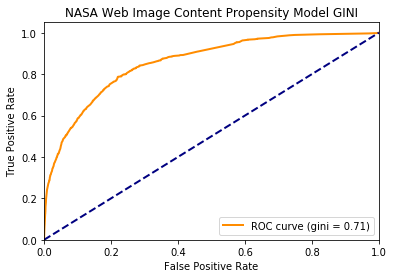

In [7]:
# Compute ROC curve and ROC area for each class
clf_XGB_score_test = clf_XGB.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.where(y_test == i, 1, 0), clf_XGB_score_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array([np.where(y_test == i, 1, 0) for i in range(2)]).ravel(), clf_XGB_score_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (gini = %0.2f)' % (2*roc_auc[0] - 1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NASA Web Image Content Propensity Model GINI')
plt.legend(loc="lower right")
plt.show()

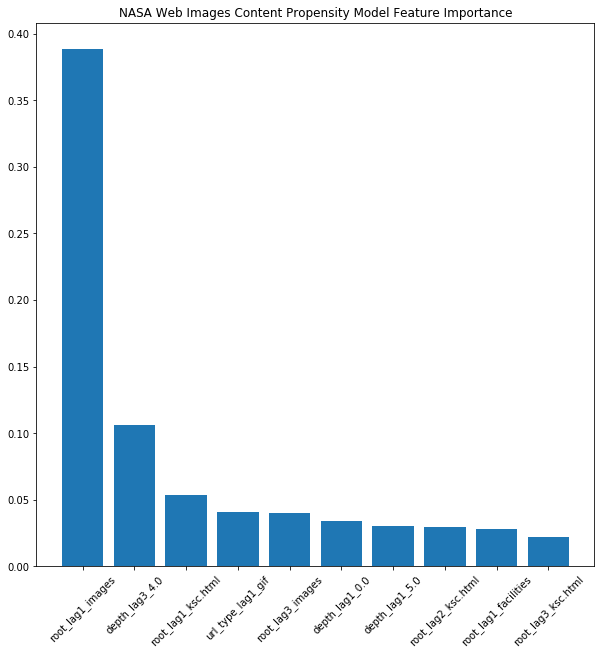

In [8]:
# Check feature importance in model
d = pd.DataFrame([[i,j] for i, j in zip(X_train.columns, clf_XGB.feature_importances_)], columns = ["feature", "importance"])
d.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize = (10,10))
plt.bar(d['feature'].iloc[:10], d['importance'].iloc[:10])
plt.title('NASA Web Images Content Propensity Model Feature Importance')
plt.xticks(rotation=45)
plt.show()

**Step 6: Build and evaluate predictive model for shuttle content** <br>
We will now develop a model to predict a user's likelihood to visit content under the **shuttle** root URL. Again, our features are based off the user's previous web browsing behaviour on the site and a number of attributes relating to their current visit. <br>
This time we will need to use the 'labe_shuttle' column for modelling outcome.

In [9]:
# We will split 80% into training and 20% into testing
X_train, X_test, y_train, y_test = train_test_split(df, labels['label_shuttle'], test_size=0.2, random_state=42)
print("We have {:2d} rows of data in our training set".format(X_train.shape[0]))
print("And {:2d} rows in our testing set".format(X_test.shape[0]))

We have 2752291 rows of data in our training set
And 688073 rows in our testing set


In [10]:
# call the XGBClassifier from xgboost library and set seed=0 to ensure reproducibility of results
clf_XGB = XGBClassifier(eta = 0.5, max_depth = 1, seed = 0, gamma = 2)
# fit the clf_XGB on training data
clf_XGB.fit(X_train, y_train)
# make predictions with test data
clf_XGB_predictions = clf_XGB.predict(X_test)
# evaluate predictions with accuracy metric
clf_XGB_accuracy_train = accuracy_score(y_train, clf_XGB.predict(X_train))
clf_XGB_accuracy_test = accuracy_score(y_test, clf_XGB_predictions)
# evaluate predictions with F1-score metric
clf_XGB_f1_train = f1_score(y_train, clf_XGB.predict(X_train))
clf_XGB_f1_test = f1_score(y_test, clf_XGB_predictions)
# evaluate probabilities with gini metric
clf_XGB_score_train = clf_XGB.predict_proba(X_train)
gini_train = (roc_auc_score(y_train, clf_XGB_score_train[:,1]) - 0.5) * 2
clf_XGB_score_test = clf_XGB.predict_proba(X_test)
gini_test = (roc_auc_score(y_test, clf_XGB_score_test[:,1]) - 0.5) * 2

print("XGB Classifier Training Performance: [Accuracy: {:.4f}, F1-score: {:.4f}, Gini: {:.4f}]".format(clf_XGB_accuracy_train, 
                                                                                                       clf_XGB_f1_train,
                                                                                                      gini_train))
print("XGB Classifier Testing Performance: [Accuracy: {:.4f}, F1-score: {:.4f}, Gini: {:.4f}]".format(clf_XGB_accuracy_test, 
                                                                                                      clf_XGB_f1_test,
                                                                                                     gini_test))

XGB Classifier Training Performance: [Accuracy: 0.7955, F1-score: 0.6539, Gini: 0.7055]
XGB Classifier Testing Performance: [Accuracy: 0.7960, F1-score: 0.6546, Gini: 0.7059]


In [11]:
train_request_rate = sum(y_train)/len(y_train)
train_average_score = np.mean(clf_XGB_score_train[:,1])
test_request_rate = sum(y_test)/len(y_test)
test_average_score = np.mean(clf_XGB_score_test[:,1])
print("Training set request rate: {:.4f}".format(train_request_rate))
print("Training set average predicted scores: {:.4f}".format(train_average_score))
print("Testing set request rate: {:.4f}".format(test_request_rate))
print("Testing set average predicted scores: {:.4f}".format(test_average_score))

Training set request rate: 0.3204
Training set average predicted scores: 0.3204
Testing set request rate: 0.3204
Testing set average predicted scores: 0.3204


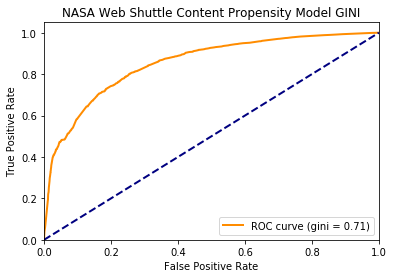

In [12]:
# Compute ROC curve and ROC area for each class
clf_XGB_score_test = clf_XGB.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.where(y_test == i, 1, 0), clf_XGB_score_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array([np.where(y_test == i, 1, 0) for i in range(2)]).ravel(), clf_XGB_score_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (gini = %0.2f)' % (2*roc_auc[0] - 1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NASA Web Shuttle Content Propensity Model GINI')
plt.legend(loc="lower right")
plt.show()

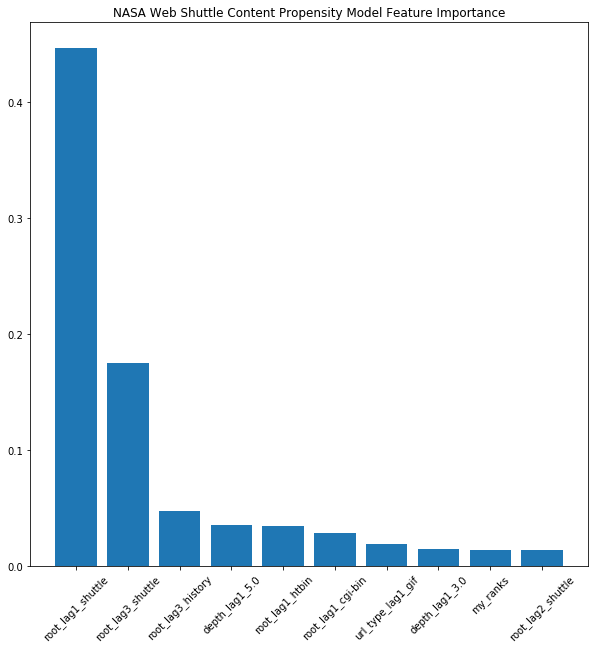

In [13]:
# Check feature importance in model
d = pd.DataFrame([[i,j] for i, j in zip(X_train.columns, clf_XGB.feature_importances_)], columns = ["feature", "importance"])
d.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize = (10,10))
plt.bar(d['feature'].iloc[:10], d['importance'].iloc[:10])
plt.title('NASA Web Shuttle Content Propensity Model Feature Importance')
plt.xticks(rotation=45)
plt.show()

**Step 6: Build and evaluate predictive model for history content** <br>
We will now develop a model to predict a user's likelihood to visit content under the **history** root URL. Again, our features are based off the user's previous web browsing behaviour on the site and a number of attributes relating to their current visit. <br>
This time we will need to use the 'labe_history' column for modelling outcome.

In [14]:
# We will split 80% into training and 20% into testing
X_train, X_test, y_train, y_test = train_test_split(df, labels['label_history'], test_size=0.2, random_state=42)
print("We have {:2d} rows of data in our training set".format(X_train.shape[0]))
print("And {:2d} rows in our testing set".format(X_test.shape[0]))

We have 2752291 rows of data in our training set
And 688073 rows in our testing set


In [15]:
# call the XGBClassifier from xgboost library and set seed=0 to ensure reproducibility of results
clf_XGB = XGBClassifier(eta = 0.5, max_depth = 1, seed = 0, gamma = 2)
# fit the clf_XGB on training data
clf_XGB.fit(X_train, y_train)
# make predictions with test data
clf_XGB_predictions = clf_XGB.predict(X_test)
# evaluate predictions with accuracy metric
clf_XGB_accuracy_train = accuracy_score(y_train, clf_XGB.predict(X_train))
clf_XGB_accuracy_test = accuracy_score(y_test, clf_XGB_predictions)
# evaluate predictions with F1-score metric
clf_XGB_f1_train = f1_score(y_train, clf_XGB.predict(X_train))
clf_XGB_f1_test = f1_score(y_test, clf_XGB_predictions)
# evaluate probabilities with gini metric
clf_XGB_score_train = clf_XGB.predict_proba(X_train)
gini_train = (roc_auc_score(y_train, clf_XGB_score_train[:,1]) - 0.5) * 2
clf_XGB_score_test = clf_XGB.predict_proba(X_test)
gini_test = (roc_auc_score(y_test, clf_XGB_score_test[:,1]) - 0.5) * 2

print("XGB Classifier Training Performance: [Accuracy: {:.4f}, F1-score: {:.4f}, Gini: {:.4f}]".format(clf_XGB_accuracy_train, 
                                                                                                       clf_XGB_f1_train,
                                                                                                      gini_train))
print("XGB Classifier Testing Performance: [Accuracy: {:.4f}, F1-score: {:.4f}, Gini: {:.4f}]".format(clf_XGB_accuracy_test, 
                                                                                                      clf_XGB_f1_test,
                                                                                                     gini_test))

XGB Classifier Training Performance: [Accuracy: 0.9236, F1-score: 0.6953, Gini: 0.8404]
XGB Classifier Testing Performance: [Accuracy: 0.9236, F1-score: 0.6961, Gini: 0.8421]


In [16]:
train_request_rate = sum(y_train)/len(y_train)
train_average_score = np.mean(clf_XGB_score_train[:,1])
test_request_rate = sum(y_test)/len(y_test)
test_average_score = np.mean(clf_XGB_score_test[:,1])
print("Training set request rate: {:.4f}".format(train_request_rate))
print("Training set average predicted scores: {:.4f}".format(train_average_score))
print("Testing set request rate: {:.4f}".format(test_request_rate))
print("Testing set average predicted scores: {:.4f}".format(test_average_score))

Training set request rate: 0.1403
Training set average predicted scores: 0.1403
Testing set request rate: 0.1406
Testing set average predicted scores: 0.1404


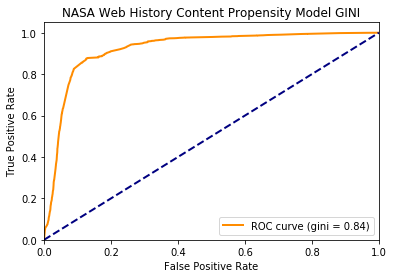

In [17]:
# Compute ROC curve and ROC area for each class
clf_XGB_score_test = clf_XGB.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.where(y_test == i, 1, 0), clf_XGB_score_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array([np.where(y_test == i, 1, 0) for i in range(2)]).ravel(), clf_XGB_score_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (gini = %0.2f)' % (2*roc_auc[0] - 1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NASA Web History Content Propensity Model GINI')
plt.legend(loc="lower right")
plt.show()

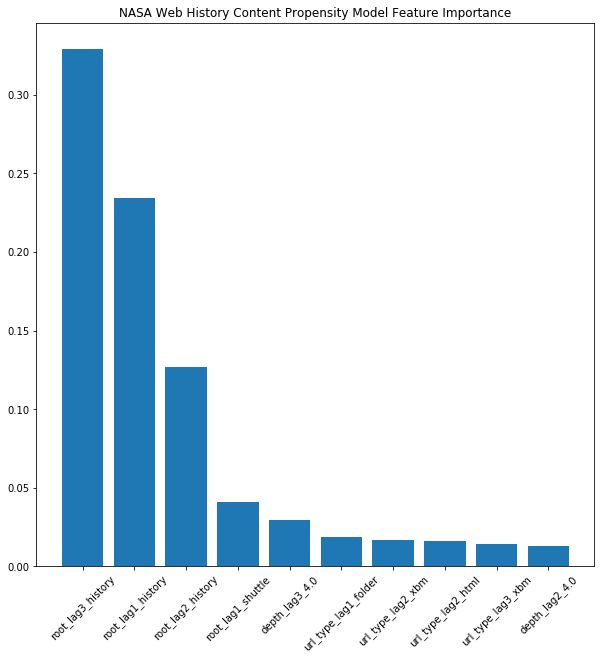

In [18]:
# Check feature importance in model
d = pd.DataFrame([[i,j] for i, j in zip(X_train.columns, clf_XGB.feature_importances_)], columns = ["feature", "importance"])
d.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize = (10,10))
plt.bar(d['feature'].iloc[:10], d['importance'].iloc[:10])
plt.title('NASA Web History Content Propensity Model Feature Importance')
plt.xticks(rotation=45)
plt.show()